In [2]:
from typing import List, Dict, Any, Optional
from langgraph.graph import StateGraph, END

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI
import pandas as pd
import numpy as np
import yfinance as yf  
import os
from langgraph.prebuilt import ToolNode 
from langchain.agents.agent_types import AgentType
import os
from google.oauth2 import service_account
from dotenv import dotenv_values
import json
import vertexai
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings, GoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

In [5]:
from langgraph.graph import StateGraph, START, END

In [6]:
config = dotenv_values("./keys/.env")
with open("./keys/complete-tube-421007-208a4862c992.json") as source:
    info = json.load(source)

vertex_credentials = service_account.Credentials.from_service_account_info(info)
vertexai.init(
    project=config["PROJECT"],
    location=config["REGION"],
    credentials=vertex_credentials,
)
google_api_key = config["GEMINI-API-KEY"]
os.environ["GEMINI_API_KEY"] = google_api_key
OPENAI_API_KEY = config.get("OPENAI_API_KEY")
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

In [7]:
# Ensure you have your OpenAI API key set as an environment variable
if "OPENAI_API_KEY" not in os.environ:
    raise ValueError("Please set the OPENAI_API_KEY environment variable.")

In [8]:
period=20

In [9]:
data = yf.download("AAPL", period=f"{period+50}d")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [10]:
data

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-11-22,229.617538,230.466611,227.809529,227.809529,38168300
2024-11-25,232.614243,232.993830,229.487690,231.205803,90152800
2024-11-26,234.801834,235.311284,233.073738,233.073738,45986200
2024-11-27,234.671982,235.431157,233.553217,234.212496,33498400
2024-11-29,237.069351,237.548820,233.713041,234.552115,28481400
...,...,...,...,...,...
2025-03-03,238.029999,244.029999,236.110001,241.789993,47184000
2025-03-04,235.929993,240.070007,234.679993,237.710007,53798100


In [11]:
import yfinance as yf
import pandas as pd

@tool
def calculate_bollinger_z_score(symbol:str, period: int = 20)-> str:
    """This tool is used to calculate the Bollinger Z Score
    I get A symbol name in the variable symbol and a period and I calculate a the Score

    Args:
        symbol (str): symbol to calculate the z-score.
        period  (int): period to calculate the score
        Returns:
        str:  Message with the relevant valuest

    """
    # Fetch historical data
    data = yf.download(symbol, period=f"{period+50}d")
    if data.empty:
        return f"Could not find data for symbol: {symbol}"

    closes = data['Close']
    rolling_mean = closes.rolling(window=period).mean()
    rolling_std = closes.rolling(window=period).std()
    upper_band = rolling_mean + (2 * rolling_std)
    lower_band = rolling_mean - (2 * rolling_std)
    z_score = (closes - rolling_mean) / rolling_std

    latest_z_score = z_score.iloc[-1].values[0]
    latest_upper_band = upper_band.iloc[-1].values[0]
    latest_lower_band = lower_band.iloc[-1].values[0]
    latest_close = closes.iloc[-1].values[0]
    
    message = f"""
    Symbol: {symbol}, Period: {period}\n
    Latest Close: {latest_close:.2f}\n
    Latest Upper Band: {latest_upper_band:.2f}\n
    Latest Lower Band: {latest_lower_band:.2f}\n
    Latest Bollinger Z-score: {latest_z_score:.2f}
    """
    return message


In [12]:
calculate_bollinger_z_score("UBS")

C:\Users\User\AppData\Local\Temp\ipykernel_83792\2940965032.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  calculate_bollinger_z_score("UBS")
[*********************100%***********************]  1 of 1 completed


'\n    Symbol: UBS, Period: 20\n\n    Latest Close: 34.15\n\n    Latest Upper Band: 34.59\n\n    Latest Lower Band: 32.85\n\n    Latest Bollinger Z-score: 0.99\n    '

In [13]:
#z_score.iloc[-1].values[0]

In [14]:

from langchain_google_genai import ChatGoogleGenerativeAI
# Set up the model

from langchain_openai import ChatOpenAI


llm = ChatOpenAI(model="gpt-4o-mini")

In [15]:
tools = [calculate_bollinger_z_score]

llm_with_tools = llm.bind_tools(tools)

In [17]:

import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.messages import ToolMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [18]:

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, MessagesState, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


def chatbot(state: State):
    """Always use tools to fulfill user requests.
    You are a clever chatbot which recomemd what to do with the stock user request based in the interpretation of the Bolling z-score

    the Bollinger Z-Score is a technical indicator used to assess the position of a security's price relative to its Bollinger Bands. It's a normalized measure that helps traders understand whether a price is relatively high or low compared to its recent trading range.

    Here's how to interpret the Bollinger Z-Score:
    
    Z-Score of 0: The current price is exactly at the middle Bollinger Band (the simple moving average).
    Positive Z-Score: The price is above the middle Bollinger Band. The higher the Z-Score, the further the price is above the average and the more "overbought" the security may be considered.
    Negative Z-Score: The price is below the middle Bollinger Band. The lower the Z-Score, the further the price is below the average and the more "oversold" the security may be considered.
    General guidelines for interpretation:
    
    Z-Score > +2: The price is considered overbought. It might be a good time to consider selling or shorting the security.
    Z-Score < -2: The price is considered oversold. It might be a good time to consider buying the security.
    Z-Score between -2 and +2: The price is within the "normal" trading range.
    Important considerations:
    
    Trend: The Z-Score should be interpreted in conjunction with the overall trend. In an uptrend, overbought conditions may persist, while in a downtrend, oversold conditions may persist.
    Volatility: The Z-Score is affected by volatility. A more volatile security will have a wider Bollinger Band and potentially larger Z-Score fluctuations.
    False Signals: The Z-Score can generate false signals, especially in trending markets. It's important to use other technical indicators and fundamental analysis to confirm trading decisions.
    
    1. If you do not have enough inputs to execute a tool then you can ask for more information.
    2. calculate the Score and return am answer based in what the tools return you and following the guidelines to  Interpretate it I give you 
    """
    # Filter out messages with image type
    # text_messages = [msg for msg in state["messages"] if msg['content'][0].get("type") != "image"]
    text_messages = [
        msg for msg in state["messages"]
        if not (isinstance(msg.content, list) and msg.content[0].get("type") == "image_url")
    ]

    # Invoke LLM with only text messages
    return {"messages": [llm_with_tools.invoke(text_messages)]}


graph_builder.add_node("chatbot", chatbot)

In [19]:

from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

memory = MemorySaver()

tool_node = ToolNode(tools)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", "__end__": "__end__"},
)

graph = graph_builder.compile()

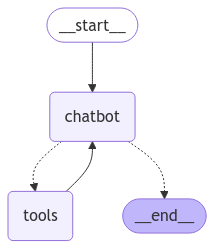

In [20]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
from langchain_core.messages import HumanMessage
import pprint
config = {"configurable": {"thread_id": "20"}}
graph.invoke(
        {
            "messages": [
                (
                    "user",
                    "Recomend if buy or sell UBS based in Calculations of the Bollinger Z-score  within a 30-day period.",
                )
            ]
        },
        config,
    )["messages"][-1].content

     


[*********************100%***********************]  1 of 1 completed


'The Bollinger Z-score for UBS over the last 30 days is 0.11. \n\n- The latest close is 34.15, which is below the upper band of 35.94 and above the lower band of 32.14.\n  \n### Interpretation:\n- A Z-score close to 0 indicates that the price is near the middle of the Bollinger Bands, suggesting a neutral market condition.\n- Typically, a Z-score above 2 indicates a potential sell signal, while a score below -2 can be a buy signal.\n\n### Recommendation:\nGiven the Z-score of 0.11, it may not be the most favorable time to either buy or sell based purely on the Bollinger Bands calculation. You may want to consider other technical indicators or market factors before making a trading decision.'

In [22]:
graph.invoke(
        {
            "messages": [
                (
                    "user",
                    "Recomend if buy or sell TSLA based in Calculations of the Bollinger Z-score  within a 20-day period.",
                )
            ]
        },
        config,
    )["messages"][-1].content

[*********************100%***********************]  1 of 1 completed


'The Bollinger Z-score for TSLA over a 20-day period is -1.52.\n\n### Interpretation:\n- A Z-score below -1.5 typically suggests that the asset is trading significantly below its historical average, which could indicate that it is undervalued.\n- Conversely, if the Z-score were above 1.5, it might suggest the asset is overvalued.\n\n### Recommendation:\nGiven that the Z-score of -1.52 indicates that TSLA is trading below its average, it might be a good opportunity to consider buying, as it could be seen as undervalued. However, always consider other factors and conduct thorough research before making investment decisions.'